In [11]:
using Revise

In [12]:
using ModelingToolkit, OrdinaryDiffEq
using ModelingToolkit: t_nounits as t, D_nounits as D

using CoolProp.CoolProp
using CoolProp.CoolProp: PropsSI
using BenchmarkTools
using Plots

In [13]:
# Helper functions
function calc_fluid_state(h, p, fluid_model)
    HP_inputs = get_input_pair_index("HmassP_INPUTS")
    AbstractState_update(Int32(fluid_model), HP_inputs, Real(h), Real(p))
    return fluid_model
end

function calc_fluid_property(property::String, fluid_state)
    property_index = get_param_index(property)
    return AbstractState_keyed_output(Int32(fluid_state), property_index)
end

# Register with more specific types for symbolic computation
@register_symbolic calc_fluid_state(h::Real, p::Real, fluid_model::Int32)
@register_symbolic calc_fluid_property(property::String, fluid_state::Int32)

In [14]:
function calc_T(h, p, fluid_model)
    HP_inputs = get_input_pair_index("HmassP_INPUTS")
    property_index = get_param_index("T")
    AbstractState_update(fluid_model, HP_inputs, h, p)
    return AbstractState_keyed_output(fluid_model, property_index)
end

@register_symbolic calc_T(h::Real, p::Real, fluid_model::Int32)

In [15]:
# Components
@connector FluidPort begin
    @parameters begin
        fluid_model::Int32
    end

    @variables begin
        h(t), [guess=0.0]
        p(t), [guess=0.0]
        ṁ(t), [guess=0.0, connect = Flow]
    end
end

@connector FluidProperties begin
    @parameters begin
        fluid_model::Int32
    end

    @variables begin
        ṁ(t), [guess=0.0, connect = Flow]
    end

    @equations begin
        ṁ ~ 0
    end
end

@mtkmodel Source begin
    @parameters begin
        h_source
        p_source
        ṁ_source
    end

    @components begin
        outlet = FluidPort()
    end

    @equations begin
        outlet.h ~ h_source
        outlet.p ~ p_source
        outlet.ṁ ~ ṁ_source
    end
end

@mtkmodel Sink begin
    @components begin
        inlet = FluidPort()
    end
end

@component function HeaterArray(; N_elements, T_Al, UA_over_dL, dL, name)

    systems = @named begin
        inlet = FluidPort()
        outlet = FluidPort()
    end
    
    vars = @variables begin
        ṁ(t)
        (T(t))[1:N_elements]
        (Q̇(t))[1:N_elements]
        (h(t))[1:N_elements]
        (p(t))[1:N_elements]
    end
    
    eqs = [
        # Conservation of mass
        ṁ ~ outlet.ṁ
        inlet.ṁ + outlet.ṁ ~ 0

        # Inlet conditions
        h[1] ~ inlet.h
        p[1] ~ inlet.p

        ## Equations for each segment
        # Heat transfer
        T[1:N_elements] ~ calc_T.(h[1:N_elements], p[1:N_elements], inlet.fluid_model)
        Q̇ ~ (T_Al .- T) * UA_over_dL * dL

        # Conservation of energy
        h[2:N_elements] ~ h[1:N_elements-1] .+ Q̇[1:N_elements-1]./ṁ

        # Conservation of momentum
        p[2:N_elements] ~ p[1:N_elements-1]

        # Outlet conditions
        h[end] ~ outlet.h
        p[end] ~ outlet.p

        domain_connect(inlet, outlet)
    ]
    
    ODESystem(eqs, t, vars, []; name, systems)
end

@mtkmodel HeatSystem begin

    @structural_parameters begin
        N_elements
        fluid_model
    end

    @parameters begin
        h_source
        p_source
        ṁ_source
        T_Al     
        dL           
        UA_over_dL
    end

    @components begin
        source = Source(h_source=h_source, p_source=p_source, ṁ_source=ṁ_source)
        heater = HeaterArray(N_elements=N_elements, T_Al=T_Al, UA_over_dL=UA_over_dL, dL=dL)
        sink = Sink()
        properties = FluidProperties(fluid_model=convert(Int32, fluid_model))
    end

    @equations begin
        connect(properties, source.outlet)
        connect(source.outlet, heater.inlet)
        connect(heater.outlet, sink.inlet)
    end
end;

In [16]:
## Inputs
# Fluid parameters
fluid_name = "Hydrogen"
eos = "TTSE&HEOS"
fluid_model = AbstractState_factory(eos, fluid_name)
ṁ = 10e-3            # kg/s
T_in = 70               # K
p_in = 350e5           # Pa
h_in = PropsSI("H", "T", T_in, "P", p_in, fluid_name);

# Wall parameters
T_Al = 50 + 273.15      # K
L = 10.0                 # m
dL = 0.1                # m
UA_over_dL = 100.0
N_elements = Int(L/dL);

In [17]:
@mtkbuild sys = HeatSystem(N_elements=N_elements, fluid_model=fluid_model,
                            h_source=h_in, p_source=p_in, ṁ_source=ṁ,
                            T_Al=T_Al, dL=dL, UA_over_dL=UA_over_dL);

┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\matth\.julia\packages\ModelingToolkit\Ljerk\src\systems\connectors.jl:54
┌ Warning: inlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\matth\.julia\packages\ModelingToolkit\Ljerk\src\systems\connectors.jl:54
┌ Warning: outlet contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\mat

In [18]:
prob = ODEProblem(sys, [], (0, 10.0));

In [19]:
L_array, T_array = @btime begin
    sol = solve(prob, Tsit5())
    L_array = [1:N_elements]*dL
    T_array = sol[sys.heater.T][end]
    return L_array, T_array
end;

  2.170 ms (11846 allocations: 411.94 KiB)


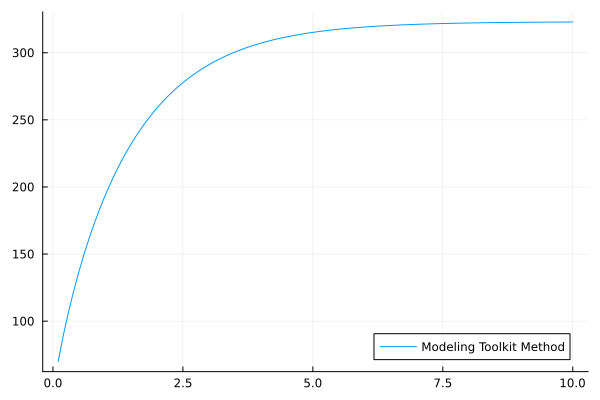

In [20]:
# Create comparison plot
p = plot(
    L_array, T_array,
    label="Modeling Toolkit Method"
)

display(p)